In [1]:
import torch
import random
import numpy as np
import pandas as pd

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Load Data from standart dataset

In [2]:
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Load Data for validation

In [3]:
MNIST_val = np.array(pd.read_csv('/content/test.csv'))
X_val = torch.from_numpy(MNIST_val.reshape(28000, 28, 28))

In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:

len(y_train), len(y_test)

(60000, 10000)

In [6]:
X_test.size()

torch.Size([10000, 28, 28])

In [7]:
X_train.size()

torch.Size([60000, 28, 28])

In [8]:
X_val.size()

torch.Size([28000, 28, 28])

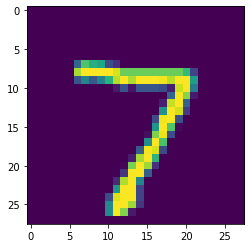

tensor(5)


In [9]:
import matplotlib.pyplot as plt
plt.imshow(X_test[0, :, :])
plt.show()
print(y_train[0])

In [10]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()
X_val = X_val.unsqueeze(1).float()

In [11]:
X_train.shape

torch.Size([60000, 1, 28, 28])

Model LeNet5

In [12]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5,
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=5, padding=2)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=3, padding=1)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=1)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [13]:
def train(net, X_train, y_train, X_test, y_test, X_val):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)
    X_val = X_val.to(device)

    for epoch in range(9):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        val_preds = net.forward(X_val)

        print(accuracy)
    print('---------------')
    return test_accuracy_history, test_loss_history, val_preds

In [14]:
accuracies = {}
losses = {}

accuracies['relu'], losses['relu'], prediction = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test, X_val)

tensor(0.9800)
tensor(0.9888)
tensor(0.9894)
tensor(0.9856)
tensor(0.9889)
tensor(0.9885)
tensor(0.9877)
tensor(0.9905)
tensor(0.9880)
---------------


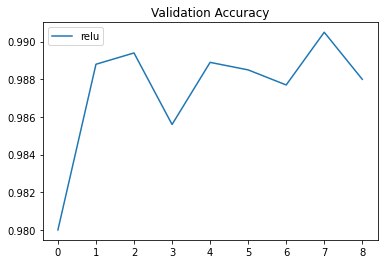

In [15]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

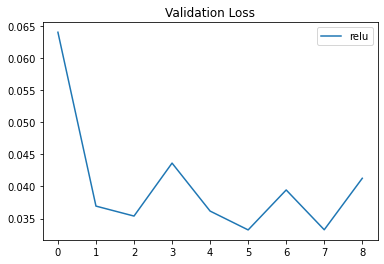

In [16]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

Take prediction and write to the submission file

In [20]:
pred = prediction.to(torch.device('cpu'))
pred = pred.detach().numpy()

array([[ -7.167673  ,  -2.8017485 ,  21.841541  , ...,   0.33252907,
         -2.4902732 ,  -3.1841543 ],
       [ 13.167944  ,  -7.266222  ,  -3.2694306 , ...,  -5.01362   ,
          1.1947684 ,  -2.921751  ],
       [ -8.311657  ,  -3.1161666 ,   0.6394174 , ...,  -0.62458014,
         -0.58779866,  14.326706  ],
       ...,
       [-12.541051  ,  -2.6961167 ,  -5.3898754 , ...,   0.8321683 ,
          2.358655  ,   0.8217121 ],
       [ -7.3821335 ,  -2.3437572 ,  -0.4345465 , ...,  -0.9104263 ,
         -2.5008376 ,  14.327222  ],
       [ -6.918433  ,  -3.1990893 ,  23.760994  , ...,  -1.0852196 ,
         -2.066646  ,  -3.2209265 ]], dtype=float32)

In [29]:
subm = pd.read_csv('/content/sample_submission.csv', index_col='ImageId')

In [30]:
subm['Label'] = np.argmax(pred, axis = 1)
subm

,Label
ImageId,
1,2
2,0
3,9
4,0
5,3
...,...
27996,9
27997,7
27998,3


In [31]:
subm.to_csv('prediction.csv')

Score 0.99442